# Credit Risk modeling (PD prediction)

Objective of this project is to calculate probability of default for a borrower and segregate potential defalters from non defaulters of a bank. The data used here is a actual bank's data without sensetive informations. 

This analysis includes roll rate analysis to select the time period to justify a defaulter, vintage analysis to select performance window, observation period analysis to select observation period.

Exploratory data analysis has been performed to explore and get insights from the data which can be used to take necessary actions and valuable informations which can be used in model building.

At last, based on the result of explanatory analysis, a machine learning model was build to segregate potential defaulters from non-defaulters based on probability of default score.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Importing data sets
credit = pd.read_csv(r'D:\Credit risk modeling\credit_record.csv')
application = pd.read_csv(r'D:\Credit risk modeling\application_record.csv')

Credit data frame holds the borrower's ID, Months balance and status.

ID - Unique ID of a borrower

Months balance - Months of the extracted data in backwards. eg. 0 refers current month and -10 referes the month 10 months back.

Status - Status of the loan in the specific month. 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month.


Application data holdes borrower's specific informations like gender, income, no of family members and so on. The fields of this data is self explanatory.

In [3]:
# Application dataframe
application.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
# Credit dataframe
credit.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
# Data cleaning
groupId = credit.groupby('ID').agg(start_month=('MONTHS_BALANCE', 'min'), end_month=('MONTHS_BALANCE', 'max'))
groupId.reset_index(inplace = True)

# Creating a column for Month on book
credit = credit.merge(groupId, on = 'ID', how = 'left')
credit['MOB'] = credit['MONTHS_BALANCE'] - credit['start_month']

#Creating observe window
credit['observe_window'] = credit['end_month'] - credit['start_month']
credit.sort_values(by = ['ID', 'MONTHS_BALANCE'], inplace = True, ignore_index = True)

# Deleting rows where Month on book is contradicting with Status of the borrower
credit.drop(credit[(credit['MOB'] < 1) & (credit['STATUS'] == '1')].index, axis = 0, inplace = True)
credit.drop(credit[(credit['MOB'] < 2) & (credit['STATUS'] == '2')].index, axis = 0, inplace = True)
credit.drop(credit[(credit['MOB'] < 3) & (credit['STATUS'] == '3')].index, axis = 0, inplace = True)
credit.drop(credit[(credit['MOB'] < 4) & (credit['STATUS'] == '4')].index, axis = 0, inplace = True)
credit.drop(credit[(credit['MOB'] < 5) & (credit['STATUS'] == '5')].index, axis = 0, inplace = True)

In [6]:
# Credit data after cleaning
credit.head()

,ID,MONTHS_BALANCE,STATUS,start_month,end_month,MOB,observe_window
0,5001711,-3,0,-3,0,0,3
1,5001711,-2,0,-3,0,1,3
2,5001711,-1,0,-3,0,2,3
3,5001711,0,X,-3,0,3,3
4,5001712,-18,0,-18,0,0,18


In [7]:
# Roll rate analysis
MOBID = credit[(credit['MOB'] == 12) & (credit['observe_window'] >= 18)][['ID', 'STATUS']].groupby(['STATUS']).nunique()
MOBID.reset_index(inplace = True)

rr = pd.DataFrame()
ls = []
for status in credit['STATUS'].unique():
    sers = credit[((credit['MOB'] == 18) & (credit['ID'].isin(credit[(credit['MOB'] == 12) &(credit['observe_window'] >= 18) & (credit['STATUS'] == status)]['ID'])))][['ID', 'STATUS']].groupby(['STATUS']).nunique()
    ls.append(status)
    rr = pd.concat([rr, sers], axis = 1)
    rr.columns = ls
    

rr = rr.T
rr.fillna(0, inplace = True)
rr.drop(['C', 'X'], axis = 0, inplace = True)
rr.drop(['C', 'X'], axis = 1, inplace = True)
rr.reset_index(inplace = True)
rr = rr.rename(columns = {'index' : 'STATUS'})

rr = rr.merge(MOBID, on = 'STATUS', how = 'left')
rr.drop('STATUS', axis = 1, inplace = True)
rr.iloc[:, :] = rr.iloc[:, :].apply(lambda x: x/x['ID'], axis = 1)
rr.drop('ID', axis = 1, inplace = True)
rr.fillna(0, inplace = True)
rr

,0,1,2,3,5
0,0.680130,0.016942,0.001220,0.000542,0.000542
1,0.346154,0.115385,0.009615,0.000000,0.044872
2,0.371429,0.057143,0.000000,0.000000,0.057143
3,0.172414,0.000000,0.000000,0.000000,0.448276
4,0.285714,0.000000,0.000000,0.000000,0.571429
5,0.023810,0.000000,0.000000,0.000000,0.595238


We can see from the above table that probability of being defaulter is more after 90 DPD. We should select 90 DPD to justify a defaulter

In [8]:
# Creating columns to tag status of the loan
credit['atleast_1-29DPD'] = np.where((credit['STATUS'] == '0') | (credit['STATUS'] == '1') |
                              (credit['STATUS'] == '2') | (credit['STATUS'] == '3') | 
                            (credit['STATUS'] == '4') | (credit['STATUS'] == '5'), 1, 0) # 1 for atleast 1-29 DPD, else 0

credit['atleast_30-59DPD'] = np.where((credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3') | 
                            (credit['STATUS'] == '4') | (credit['STATUS'] == '5'), 1, 0) # 1 for atleast 30-59 days DPD, else 0

credit['atleast_60-89DPD'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3') | 
                            (credit['STATUS'] == '4') | (credit['STATUS'] == '5'), 1, 0) # 1 for atleast 60-89 days DPD, else 0

credit['atleast_90-119DPD'] = np.where((credit['STATUS'] == '3') | 
                            (credit['STATUS'] == '4') | (credit['STATUS'] == '5'), 1, 0) # 1 for atleast 90-119 days DPD, else 0

credit['atleast_120-149DPD'] = np.where((credit['STATUS'] == '4') | (credit['STATUS'] == '5'), 1, 0) # 1 for atleast 120-149 days DPD, else 0

credit['more_than_150DPD'] = np.where((credit['STATUS'] == '5'), 1, 0) # 1 for overdue or bad debts, write-offs for more than 150 days, else 0

# Deleting those IDs opened loan account less than 12 months
credit = credit[credit['observe_window'] > 12]

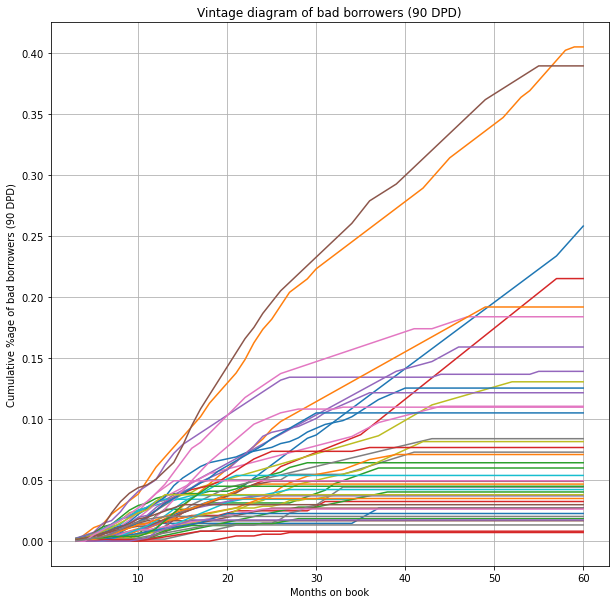

In [9]:
# Vintage analysis to select performance window
vintage = pd.pivot_table(credit[credit['atleast_90-119DPD'] == 1], index = 'start_month', columns = 'MOB', values = 'ID', aggfunc = lambda x: len(x.unique())).fillna(0).cumsum(axis = 1)
vintage.reset_index(inplace = True)

start_monthGroup = credit[['start_month', 'ID']].groupby('start_month').nunique()
start_monthGroup.reset_index(inplace = True)

vintage = vintage.merge(start_monthGroup, on = 'start_month', how = 'left')
vintage.iloc[:, 1:] = vintage.iloc[:, 1:].apply(lambda x: x/x['ID'], axis = 1)

vintage.drop('ID', axis = 1, inplace = True)
vintage.T.drop('start_month', axis = 0).plot(legend = False, grid = True, title = 'Vintage diagram of bad borrowers (90 DPD)', figsize = (10, 10))
plt.xlabel('Months on book')
plt.ylabel('Cumulative %age of bad borrowers (90 DPD)')
plt.show()

From above chart, we can observe an elbow in 30 months point. That means, maximum defaulter we can cover in 30 months

Text(0, 0.5, 'Cumulate %age of bad borrowers')

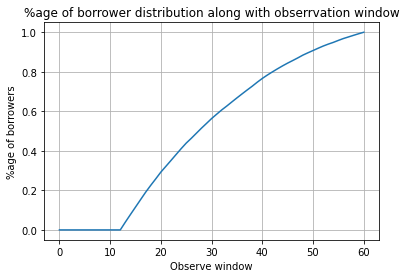

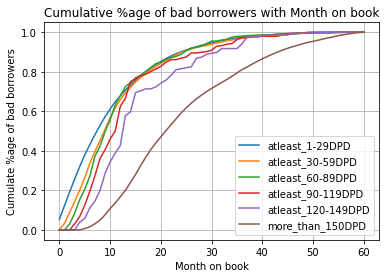

In [11]:
# Observe window section
ls = []
for i in np.arange(0, 61, 1):
    ls.append(credit[credit['observe_window'] <= i]['ID'].nunique()/ credit['ID'].nunique())

pd.Series(ls).plot(grid = True, title = '%age of borrower distribution along with obserrvation window')
plt.xlabel('Observe window')
plt.ylabel('%age of borrowers')

observe = pd.pivot_table(credit[['ID', 'atleast_1-29DPD', 'atleast_30-59DPD',
       'atleast_60-89DPD', 'atleast_90-119DPD', 'atleast_120-149DPD',
       'more_than_150DPD', 'MOB']], index = 'MOB', 
               columns = ['atleast_1-29DPD', 'atleast_30-59DPD',
       'atleast_60-89DPD', 'atleast_90-119DPD', 'atleast_120-149DPD',
       'more_than_150DPD'], values = 'ID', aggfunc = lambda x: len(x.unique())).fillna(0).cumsum(axis = 0)

observe.columns = ['status_null', 'atleast_1-29DPD', 'atleast_30-59DPD',
       'atleast_60-89DPD', 'atleast_90-119DPD', 'atleast_120-149DPD',
       'more_than_150DPD']

# observe.reset_index(inplace = True)

observe.drop('status_null', inplace = True, axis = 1)

observe.apply(lambda x: x/x.max(), axis = 0).plot(grid = True, title = 'Cumulative %age of bad borrowers with Month on book')
plt.xlabel('Month on book')
plt.ylabel('Cumulate %age of bad borrowers')

From the above observe window chart, we can see that almost 80% borrower's data can be covered in 40 months period in 60 months time frame.

The second chart is a supporting chart to support 30 months performance window. We can observe, if we treat each loan status separately, then also, in 30 months, we can cover more than 85% of total defaulters.

Final decisions

90 DPD logic to tag a borrower a defaulter

Observation window = atleast 40 months

Performance window = 30 months

In [12]:
# Tagging borrowers as defaulters and non-defaulters
credit.loc[((credit['atleast_90-119DPD'] == 1) & (credit['observe_window'] >= 40) & (credit['MOB'] <= 30)), 'default'] = 1
credit['default'].fillna(0, inplace = True)

In [13]:
# Checking the Defaulters and non-defaulters distributions in the credit data
credit['default'].value_counts()

0.0    924885
1.0       773
Name: default, dtype: int64

In [14]:
# Tagging borrowers in application data
application = application.merge(credit[['ID', 'default']].drop_duplicates(), on = 'ID', how = 'left')
application.drop(application[application['default'].isna()].index, axis = 0, inplace = True)

# ===============Explanatory data analysis (EDA)===============

In [15]:
# Checking the Defaulters and non-defaulters distributions in the application data
application['default'].value_counts()

0.0    22290
1.0      111
Name: default, dtype: int64

In [16]:
# application data first 5 rows
application.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,default
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0


In [17]:
# Changing data types of few fields
application = application.astype(dtype =  {'FLAG_OWN_CAR' : 'object',
                                           'FLAG_OWN_REALTY' : 'object',
                                           'FLAG_MOBIL' : 'object',
                                           'FLAG_WORK_PHONE' : 'object',
                                           'FLAG_PHONE' : 'object',
                                           'FLAG_EMAIL' : 'object',
                                           'default' : 'object'})

In [18]:
# Deleting rows with less no of family members than no of child which does not make sense
application = application[application['CNT_FAM_MEMBERS'] > application['CNT_CHILDREN']]

# Tagging positive days employment as 0, (For Pensioners)
application.loc[(application['DAYS_EMPLOYED'] >= 0), 'DAYS_EMPLOYED'] = 0

In [19]:
# Description of application data
application.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,2.239300e+04,22393.000000,2.239300e+04,22393.000000,22393.000000,22393.000000
mean,5.078915e+06,0.430268,1.893235e+05,-16083.609878,-2315.544367,2.209306
std,4.198587e+04,0.737143,1.020736e+05,4104.246185,2415.030456,0.902637
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000
25%,5.044502e+06,0.000000,1.237500e+05,-19431.000000,-3270.000000,2.000000
50%,5.078782e+06,0.000000,1.665000e+05,-15670.000000,-1682.000000,2.000000
75%,5.115695e+06,1.000000,2.250000e+05,-12676.000000,-451.000000,3.000000
max,5.150487e+06,14.000000,1.575000e+06,-7757.000000,0.000000,15.000000


In [20]:
# Checking null values scenarios in application data
application.isna().sum()

ID                        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE        6855
CNT_FAM_MEMBERS           0
default                   0
dtype: int64

In [21]:
# We have observed Null values in Occupation type, We will assign nearest category to this null category.
# We will check the average values of continuous fields and check the nearest possible category from the Occupation type.
application[application['OCCUPATION_TYPE'].isna()][['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']].mean()

DAYS_BIRTH          -18578.628155
DAYS_EMPLOYED        -1365.219256
AMT_INCOME_TOTAL    170805.590153
CNT_CHILDREN             0.254413
CNT_FAM_MEMBERS          2.000875
dtype: float64

In [22]:
# This is the table to find out nearest occupation type for the null occupation type
pd.pivot_table(data = application, index = 'OCCUPATION_TYPE', values = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS'], aggfunc = 'mean')

,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,DAYS_BIRTH,DAYS_EMPLOYED
OCCUPATION_TYPE,,,,,
Accountants,209094.535176,0.458543,2.223618,-15381.827889,-2663.255025
Cleaning staff,147219.230769,0.347692,1.932308,-17933.470769,-2502.920000
Cooking staff,145275.979112,0.344648,2.156658,-15123.644909,-2382.368146
Core staff,192381.737040,0.606557,2.388569,-14354.373948,-2994.540541
Drivers,208955.000000,0.545926,2.425926,-15008.151111,-2034.060741
HR staff,197315.217391,0.500000,2.043478,-14529.326087,-2060.326087
High skill tech staff,198766.019417,0.518878,2.311758,-15285.887810,-3266.566343
IT staff,214707.692308,0.461538,2.179487,-13424.564103,-1777.230769
Laborers,181508.672328,0.490724,2.277763,-14800.619284,-2800.544813


In [23]:
# Occupation null is nearest to Security staff. We will assign this category to these null cases
application.loc[application['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = 'Security staff'

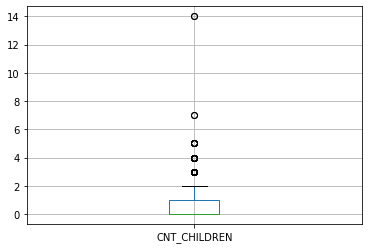

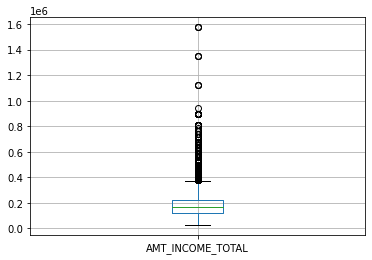

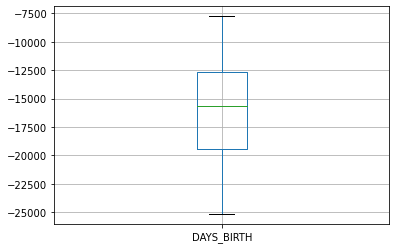

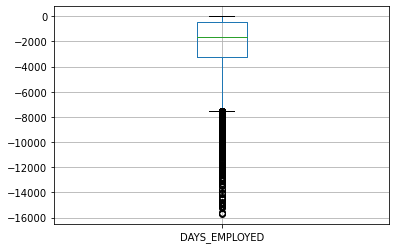

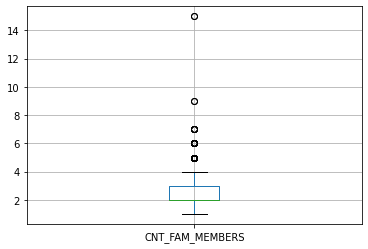

In [24]:
# Box plot to check distribution of continuous variables individually
for col in application.select_dtypes(exclude = 'object').columns[1:]:
    application.boxplot(column = col)
    plt.show()

In [25]:
# Manually trimming the application data to make the data more clean
application = application[application['CNT_CHILDREN'] < 4]
application = application[application['CNT_FAM_MEMBERS'] < 6]
application = application[application['AMT_INCOME_TOTAL'] < 800000]

In [26]:
# Changing the format of Days_employed and days_birth to make more sense
application['DAYS_BIRTH'] = application['DAYS_BIRTH'].apply(lambda x: int(abs(x)/365))
application['DAYS_EMPLOYED'] = application['DAYS_EMPLOYED'].apply(lambda x: int(abs(x)/365))

In [27]:
# What was the least and maximum age of a borrower when they started working (Exclusing pensioners as their data is not provided properly)
# What was the min age of a borrower when they starte working
print('The minimum age at the starting of employment is: ', (application[application['DAYS_EMPLOYED'] != 0]['DAYS_BIRTH'] - application[application['DAYS_EMPLOYED'] != 0]['DAYS_EMPLOYED']).min())

# What was the max age of a borrower when they starte working
print('The maximum age at the starting of employment is: ', (application[application['DAYS_EMPLOYED'] != 0]['DAYS_BIRTH'] - application[application['DAYS_EMPLOYED'] != 0]['DAYS_EMPLOYED']).max())

The minimum age at the starting of employment is:  17
The maximum age at the starting of employment is:  63


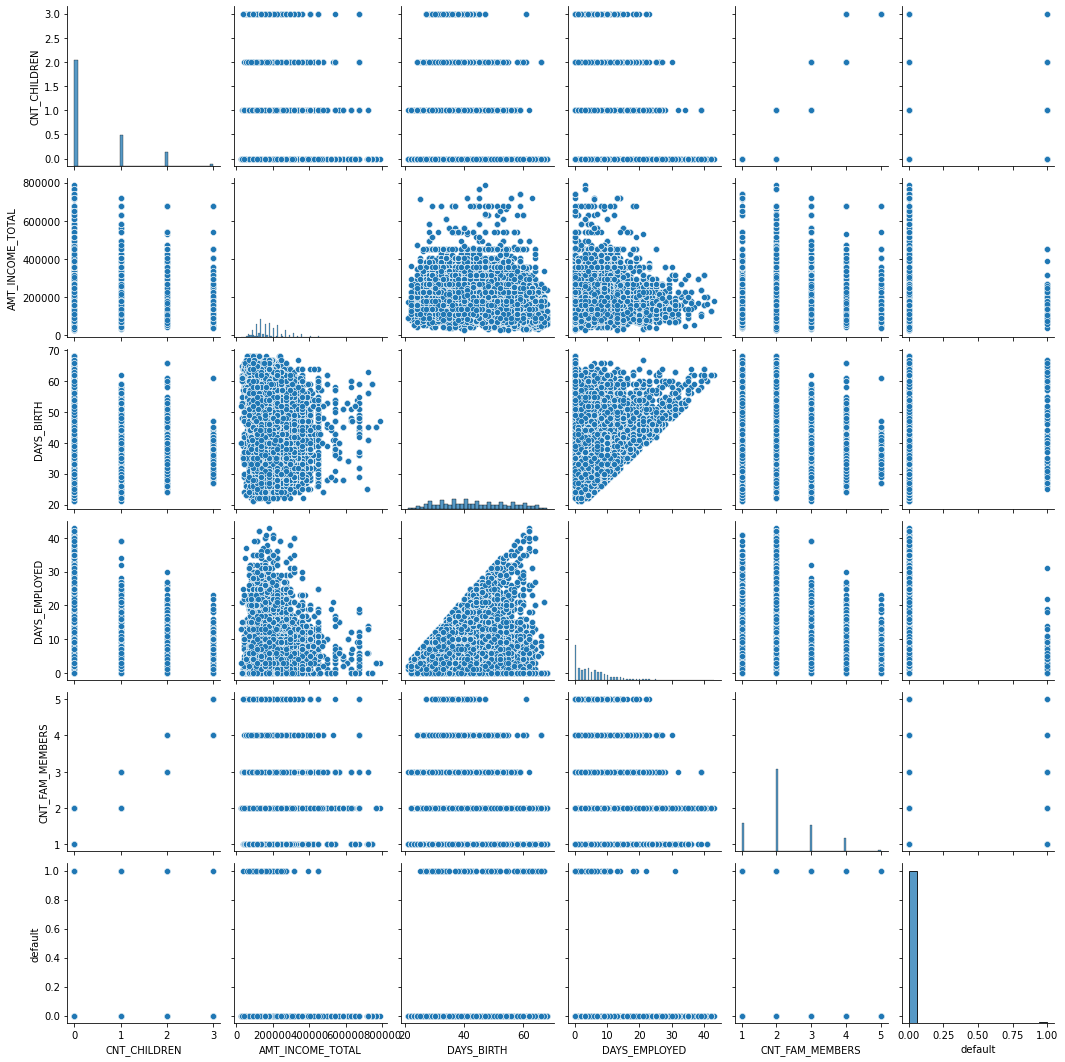

In [28]:
# Correlation plot for continuous fields. Adding target variable (default) to check the data distribution of other fields along side of target class
sns.pairplot(data = application[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'default']])

# Calculating Odds, Weight of evidence, Information values

# Gender

In [29]:
# Frequency table of target variable default and Gender with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['CODE_GENDER', 'ID', 'default']], index = 'CODE_GENDER', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
CODE_GENDER,,,,,
F,14756,68,0.004608,0.082166,0.004311
M,7431,43,0.005787,-0.145516,0.007634


In [30]:
# Information value of Gender
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['CODE_GENDER', 'ID', 'default']], index = 'CODE_GENDER', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.011944532992532607

The Information value is less than 0.02, We can drop this field from model building

# FLAG_OWN_CAR

In [31]:
# Frequency table of target variable default and flag_own_car with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_OWN_CAR', 'ID', 'default']], index = 'FLAG_OWN_CAR', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
FLAG_OWN_CAR,,,,,
N,13500,69,0.005111,-0.021393,0.000281
Y,8687,42,0.004835,0.034182,0.000450


In [32]:
# Information value of flag_own_car
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_OWN_CAR', 'ID', 'default']], index = 'FLAG_OWN_CAR', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.0007312098041912611

The Information value is less than 0.02, We can drop this field from model building

# FLAG_OWN_REALTY

In [33]:
# Frequency table of target variable default and flag_own_realty with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_OWN_REALTY', 'ID', 'default']], index = 'FLAG_OWN_REALTY', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
FLAG_OWN_REALTY,,,,,
N,7635,42,0.005501,-0.094903,0.003251
Y,14552,69,0.004742,0.053646,0.001838


In [34]:
# Information value of flag_own_realty
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_OWN_REALTY', 'ID', 'default']], index = 'FLAG_OWN_REALTY', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.005088970695371671

The Information value is less than 0.02, We can drop this field from model building

# Name Income Type

In [35]:
# Frequency table of target variable default and name income type with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_INCOME_TYPE', 'ID', 'default']], index = 'NAME_INCOME_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
NAME_INCOME_TYPE,,,,,
Commercial associate,5248.0,28.0,0.005335,-0.064334,0.001011
Pensioner,3596.0,29.0,0.008065,-0.477450,0.047356
State servant,1887.0,10.0,0.005299,-0.057573,0.000290
Student,10.0,NaN,NaN,NaN,NaN
Working,11446.0,44.0,0.003844,0.263474,0.031483


In [36]:
# Excluding students from analysis as there is defaulters
application = application[application['NAME_INCOME_TYPE'] != 'Student']

In [37]:
# Information value of name income type
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_INCOME_TYPE', 'ID', 'default']], index = 'NAME_INCOME_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.08015713982825275

The Information value is more than 0.02, We can keep this field in model building

# Occupation type

In [38]:
# Frequency table of target variable default and occupation type with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['OCCUPATION_TYPE', 'ID', 'default']], index = 'OCCUPATION_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
OCCUPATION_TYPE,,,,,
Accountants,791.0,5.0,0.006321,-0.233421,0.002189
Cleaning staff,322.0,1.0,0.003106,0.477271,0.002630
Cooking staff,381.0,2.0,0.005249,-0.047629,0.000040
Core staff,2212.0,15.0,0.006781,-0.303679,0.010748
Drivers,1340.0,7.0,0.005224,-0.042766,0.000113
HR staff,46.0,NaN,NaN,NaN,NaN
High skill tech staff,915.0,5.0,0.005464,-0.087795,0.000332
IT staff,39.0,NaN,NaN,NaN,NaN
Laborers,3803.0,18.0,0.004733,0.055893,0.000521


In [39]:
# Deleting few types of Occupation where there is no defaulters
application = application[~application['OCCUPATION_TYPE'].isin(['HR staff', 'IT staff', 'Realty agents', 'Secretaries', 'Waiters/barmen staff'])]

In [40]:
# Information value of occupation type
pd.pivot_table(data = application[['OCCUPATION_TYPE', 'ID', 'default']], index = 'OCCUPATION_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.05853971448959082

The Information value is more than 0.02, We can keep this field in model building

# Name housing type

In [41]:
# Frequency table of target variable default and name housing type with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_HOUSING_TYPE', 'ID', 'default']], index = 'NAME_HOUSING_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
NAME_HOUSING_TYPE,,,,,
Co-op apartment,96,1,0.010417,-0.720227,0.003331
House / apartment,19579,93,0.004750,0.065039,0.003662
Municipal apartment,720,8,0.011111,-0.784765,0.030756
Office apartment,156,2,0.012821,-0.927866,0.010108
Rented apartment,322,2,0.006211,-0.203170,0.000673
With parents,1024,5,0.004883,0.037459,0.000064


In [42]:
# Information value of new housing type
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_HOUSING_TYPE', 'ID', 'default']], index = 'NAME_HOUSING_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.048593828106986134

The Information value is more than 0.02, We can keep this field in model building

# Name education type

In [43]:
# Frequency table of target variable default and name education type with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_EDUCATION_TYPE', 'ID', 'default']], index = 'NAME_EDUCATION_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
NAME_EDUCATION_TYPE,,,,,
Academic degree,26.0,NaN,NaN,NaN,NaN
Higher education,6017.0,39.0,0.006482,-0.245792,0.018819
Incomplete higher,865.0,8.0,0.009249,-0.601287,0.019583
Lower secondary,242.0,5.0,0.020661,-1.405075,0.047763
Secondary / secondary special,14747.0,59.0,0.004001,0.236683,0.033595


In [44]:
# Converting Academic degree to Lower secondary and Incomplete higher to secondary type
application['NAME_EDUCATION_TYPE'] = application['NAME_EDUCATION_TYPE'].replace({'Academic degree' : 'Lower secondary', 'Incomplete higher' : 'Secondary / secondary special'})

In [45]:
# Information value of new education type
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_EDUCATION_TYPE', 'ID', 'default']], index = 'NAME_EDUCATION_TYPE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.0797792861853425

The Information value is more than 0.02, We can keep this field in model building

# Name family status

In [47]:
# Frequency table of target variable default and name family status with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_FAMILY_STATUS', 'ID', 'default']], index = 'NAME_FAMILY_STATUS', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
NAME_FAMILY_STATUS,,,,,
Civil marriage,1676,5,0.002983,0.530153,0.016697
Married,15370,70,0.004554,0.107103,0.007636
Separated,1310,13,0.009924,-0.671742,0.038485
Single / not married,2715,16,0.005893,-0.150616,0.003036
Widow,826,7,0.008475,-0.513890,0.013022


In [48]:
# Information value of name family status
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['NAME_FAMILY_STATUS', 'ID', 'default']], index = 'NAME_FAMILY_STATUS', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.07887602707281108

The Information value is more than 0.02, We can keep this field in model building

# Flag Mobile

In [49]:
# Frequescy table of target variable default and flag mobile with Odds value
pd.pivot_table(data = application[['FLAG_MOBIL', 'ID', 'default']], index = 'FLAG_MOBIL', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0])

default,0.0,1.0,odds
FLAG_MOBIL,,,
1,21897,111,0.005069


We will exclude this field from the model as there is only one class in this field

# Flag work phone

In [50]:
# Frequency table of target variable default and name flag work phone with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_WORK_PHONE', 'ID', 'default']], index = 'FLAG_WORK_PHONE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
FLAG_WORK_PHONE,,,,,
0,16781,78,0.004648,0.086719,0.005520
1,5116,33,0.006450,-0.240954,0.015339


In [51]:
# Information value of flag work phone
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_WORK_PHONE', 'ID', 'default']], index = 'FLAG_WORK_PHONE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.0208590124742076

The Information value is more than 0.02, We can keep this field in model building

# Flag phone

In [53]:
# Frequency table of target variable default and flag phone with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_PHONE', 'ID', 'default']], index = 'FLAG_PHONE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
FLAG_PHONE,,,,,
0,15326,72,0.004698,0.076065,0.003899
1,6571,39,0.005935,-0.157715,0.008085


In [54]:
# Information value of flag phone
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_PHONE', 'ID', 'default']], index = 'FLAG_PHONE', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.011984645737403743

The Information value is less than 0.02, We can drop this field from model building

# Flag Email

In [55]:
# Frequency table of target variable default and flag email with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_EMAIL', 'ID', 'default']], index = 'FLAG_EMAIL', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
FLAG_EMAIL,,,,,
0,19890,102,0.005128,-0.011575,0.000122
1,2007,9,0.004484,0.122597,0.001297


In [56]:
# Information value of flag email
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['FLAG_EMAIL', 'ID', 'default']], index = 'FLAG_EMAIL', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.0014189127723236363

The Information value is less than 0.02, We can drop this field from model building

# Days Birth

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Count'>

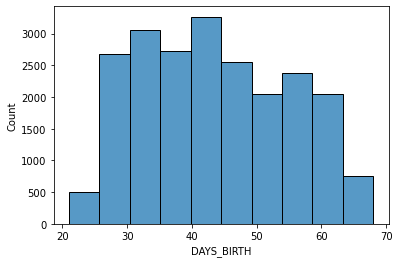

In [57]:
# Histogram plot to check the data distribution of days_birth
sns.histplot(data = application, x = 'DAYS_BIRTH', bins = 10)

In [58]:
# We will create 11 bins to make days_birth field categorical
birth_bin = np.arange(application['DAYS_BIRTH'].min(), application['DAYS_BIRTH'].max()+1, (application['DAYS_BIRTH'].max() - application['DAYS_BIRTH'].min())/10)
application['DAYS_BIRTH_BIN'] = np.digitize(application['DAYS_BIRTH'], birth_bin)

In [60]:
# Frequency table of target variable default and DAYS_BIRTH_BIN with Odds value, weight of evidence and Information value
pd.pivot_table(data = application[['DAYS_BIRTH_BIN', 'ID', 'default']], index = 'DAYS_BIRTH_BIN', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
DAYS_BIRTH_BIN,,,,,
1,495.0,1.0,0.002020,0.919983,0.012509
2,2660.0,15.0,0.005639,-0.106544,0.001455
3,3046.0,17.0,0.005581,-0.096204,0.001351
4,2717.0,4.0,0.001472,1.236415,0.108860
5,3248.0,18.0,0.005542,-0.089152,0.001233
6,2546.0,11.0,0.004321,0.159809,0.002744
7,2044.0,11.0,0.005382,-0.059806,0.000344
8,2361.0,11.0,0.004659,0.084371,0.000736
9,2035.0,15.0,0.007371,-0.374374,0.015799


In [61]:
# We can drop 11th Bin as there is no defaulter
application = application[~application['DAYS_BIRTH_BIN'].isin([11])]

In [62]:
# Information value of DAYS_BIRTH_BIN
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['DAYS_BIRTH_BIN', 'ID', 'default']], index = 'DAYS_BIRTH_BIN', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.1758969591506346

The Information value is more than 0.02, We can keep this field in model building

<AxesSubplot:xlabel='DAYS_BIRTH_BIN', ylabel='default'>

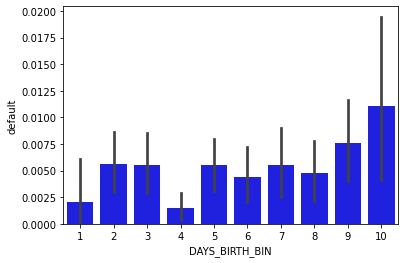

In [70]:
# Check the average numbers defaulters in each bucket
sns.barplot(data = application, x = 'DAYS_BIRTH_BIN', y = 'default', color = 'blue')

# Days employed

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Count'>

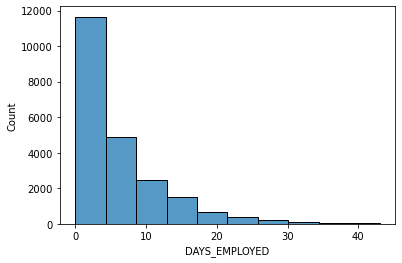

In [63]:
# Histogram plot to check the data distribution of days_employed
sns.histplot(data = application, x = 'DAYS_EMPLOYED', bins = 10)

In [64]:
# We will create 11 bins for DAYS_EMPLOYED field and separately create 1 bin for pensioners
min_employed_days = application[application['DAYS_EMPLOYED'] != 0]['DAYS_EMPLOYED'].min()
max_emplyed_days = application[application['DAYS_EMPLOYED'] != 0]['DAYS_EMPLOYED'].max()

employed_bin = np.arange(min_employed_days, max_emplyed_days+1, (max_emplyed_days - min_employed_days)/10)
application.loc[application['DAYS_EMPLOYED'] != 0, 'DAYS_EMPLOYED_BIN'] = np.digitize(application[application['DAYS_EMPLOYED'] != 0]['DAYS_EMPLOYED'], employed_bin)
application.loc[application['DAYS_EMPLOYED_BIN'].isna(), 'DAYS_EMPLOYED_BIN'] = 12

In [65]:
# Frequency table of target variable default and DAYS_EMPLOYED_BIN with Odds value, weight of evidence and Information value
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['DAYS_EMPLOYED_BIN', 'ID', 'default']], index = 'DAYS_EMPLOYED_BIN', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])

default,0.0,1.0,odds,woe,IV
DAYS_EMPLOYED_BIN,,,,,
1.0,7794.0,46.0,0.005902,-0.150964,0.008766
2.0,4474.0,13.0,0.002906,0.557656,0.048760
3.0,2017.0,7.0,0.003471,0.380024,0.011080
4.0,1085.0,1.0,0.000922,1.705903,0.069256
5.0,670.0,2.0,0.002985,0.530698,0.006695
6.0,469.0,1.0,0.002132,0.867170,0.010782
7.0,183.0,NaN,NaN,NaN,NaN
8.0,101.0,1.0,0.009901,-0.668312,0.002935
9.0,40.0,NaN,NaN,NaN,NaN


In [67]:
# We will delete few categories from DAYS_EMPLOYED_BIN as there is no defaulters
application = application[~application['DAYS_EMPLOYED_BIN'].isin([7, 9, 10, 11])]

In [68]:
# Information value of DAYS_EMPLOYED_BIN
total_non_default, total_default = application['default'].value_counts()[0], application['default'].value_counts()[1]
pd.pivot_table(data = application[['DAYS_EMPLOYED_BIN', 'ID', 'default']], index = 'DAYS_EMPLOYED_BIN', columns = 'default', values = 'ID',
              aggfunc = 'nunique').assign(odds = lambda x : x[1]/x[0]).assign(woe = lambda x : np.log((x[0]/ total_non_default)/ (x[1]/total_default))).assign(IV = lambda x : ((x[0]/ total_non_default) - (x[1]/total_default))*x['woe'])['IV'].sum()

0.2198556523418836

The Information value is more than 0.02, We can keep this field in model building

<AxesSubplot:xlabel='DAYS_EMPLOYED_BIN', ylabel='default'>

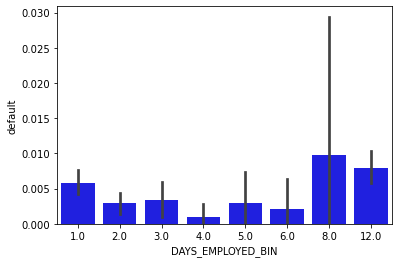

In [69]:
# Check the average numbers defaulters in each bucket
sns.barplot(data = application, x = 'DAYS_EMPLOYED_BIN', y = 'default', color = 'blue')

In [71]:
# Cheange the data type of newly added fields in application data
application = application.astype(dtype = {
    'DAYS_BIRTH_BIN' : 'object',
    'DAYS_EMPLOYED_BIN' : 'object'
})

In [98]:
# Chi-square test for independence between target variable default and categorical fields

print('Chi-square test of significance between default and Gender, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['CODE_GENDER']), correction = True)[1])
print('Chi-square test of significance between default and FLAG_OWN_CAR, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['FLAG_OWN_CAR']), correction = True)[1])
print('Chi-square test of significance between default and FLAG_OWN_REALTY, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['FLAG_OWN_REALTY']), correction = True)[1])
print('Chi-square test of significance between default and NAME_INCOME_TYPE, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['NAME_INCOME_TYPE']), correction = False)[1])
print('Chi-square test of significance between default and NAME_EDUCATION_TYPE, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['NAME_EDUCATION_TYPE']), correction = False)[1])
print('Chi-square test of significance between default and NAME_FAMILY_STATUS, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['NAME_FAMILY_STATUS']), correction = False)[1])
print('Chi-square test of significance between default and NAME_HOUSING_TYPE, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['NAME_HOUSING_TYPE']), correction = False)[1])
print('Chi-square test of significance between default and FLAG_WORK_PHONE, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['FLAG_WORK_PHONE']), correction = True)[1])
print('Chi-square test of significance between default and FLAG_PHONE, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['FLAG_PHONE']), correction = True)[1])
print('Chi-square test of significance between default and FLAG_EMAIL, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['FLAG_EMAIL']), correction = True)[1])
print('Chi-square test of significance between default and OCCUPATION_TYPE, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['OCCUPATION_TYPE']), correction = False)[1])
print('Chi-square test of significance between default and DAYS_BIRTH_BIN, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['DAYS_BIRTH_BIN']), correction = False)[1])
print('Chi-square test of significance between default and DAYS_EMPLOYED_BIN, P value is: ', chi2_contingency(pd.crosstab(columns= application['default'], index = application['DAYS_EMPLOYED_BIN']), correction = False)[1])

Chi-square test of significance between default and Gender, P value is:  0.9468413326574614
Chi-square test of significance between default and FLAG_OWN_CAR, P value is:  0.9810817787876268
Chi-square test of significance between default and FLAG_OWN_REALTY, P value is:  0.001746683332866821
Chi-square test of significance between default and NAME_INCOME_TYPE, P value is:  0.06176248819185502
Chi-square test of significance between default and NAME_EDUCATION_TYPE, P value is:  0.014393888773132836
Chi-square test of significance between default and NAME_FAMILY_STATUS, P value is:  0.01109396458771273
Chi-square test of significance between default and NAME_HOUSING_TYPE, P value is:  0.0679808044736192
Chi-square test of significance between default and FLAG_WORK_PHONE, P value is:  0.10954902352305593
Chi-square test of significance between default and FLAG_PHONE, P value is:  0.2956191699679673
Chi-square test of significance between default and FLAG_EMAIL, P value is:  0.850446855297

We would first try to use fields in model based on their information value rather than relying on statstical test.

In [74]:
# Checking the mean difference in default and non-default class across continuous variables
pd.pivot_table(application, index = 'default', values = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS'], aggfunc = 'mean')

,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,DAYS_BIRTH,DAYS_EMPLOYED
default,,,,,
0.0,187997.501481,0.425986,2.206258,43.445149,5.626967
1.0,174186.486486,0.333333,2.036036,45.693694,3.621622


In [75]:
# Checking the median difference in default and non-default class across continuous variables
pd.pivot_table(application, index = 'default', values = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS'], aggfunc = 'median')

,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,DAYS_BIRTH,DAYS_EMPLOYED
default,,,,,
0.0,166500.0,0,2.0,42,4
1.0,180000.0,0,2.0,46,2


# =============== Model building ===============

In [78]:
# Creating dummy variables for categorical variables in application data
x_cat = pd.get_dummies(application[['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'DAYS_BIRTH_BIN', 'DAYS_EMPLOYED_BIN']], drop_first = True)

# Considering flag work phone field
x_flag = application['FLAG_WORK_PHONE']
x_flag = x_flag.astype('uint8')

# Considering continuous variables in the model
x_continuous = application[['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']]

In [80]:
# Independent variables
x = pd.concat([x_cat, x_flag, x_continuous], axis = 1, ignore_index = False)

# Dependent variable
y = application['default']

In [81]:
# Labeling the dependent variable (Default & Non-default)
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [82]:
print('Total number of non defaulters: ', len(y) - y.sum())
print('Total number of defaulters: ', y.sum())

Total number of non defaulters:  21604
Total number of defaulters:  111


In [83]:
# Following oversampling methodology to make this imbalanced data balanced
os = RandomOverSampler(sampling_strategy= 0.5)
x_over, y_over = os.fit_resample(x, y)

In [84]:
# Checking the balance in defalut and Non-default class after over sampling minor class
print('Total number of non defaulters: ', len(y_over) - y_over.sum())
print('Total number of defaulters: ', y_over.sum())

Total number of non defaulters:  21604
Total number of defaulters:  10802


In [85]:
# Creating training and test data set with 80-20 ratio
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size = 0.2, random_state = 42)

In [86]:
# Decision tree model
penalty = {
    0 : 1,
    1: 2
}
model_ds = DecisionTreeClassifier(min_samples_leaf = 2, random_state = 42, class_weight = penalty).fit(x_train, y_train)

<AxesSubplot:>

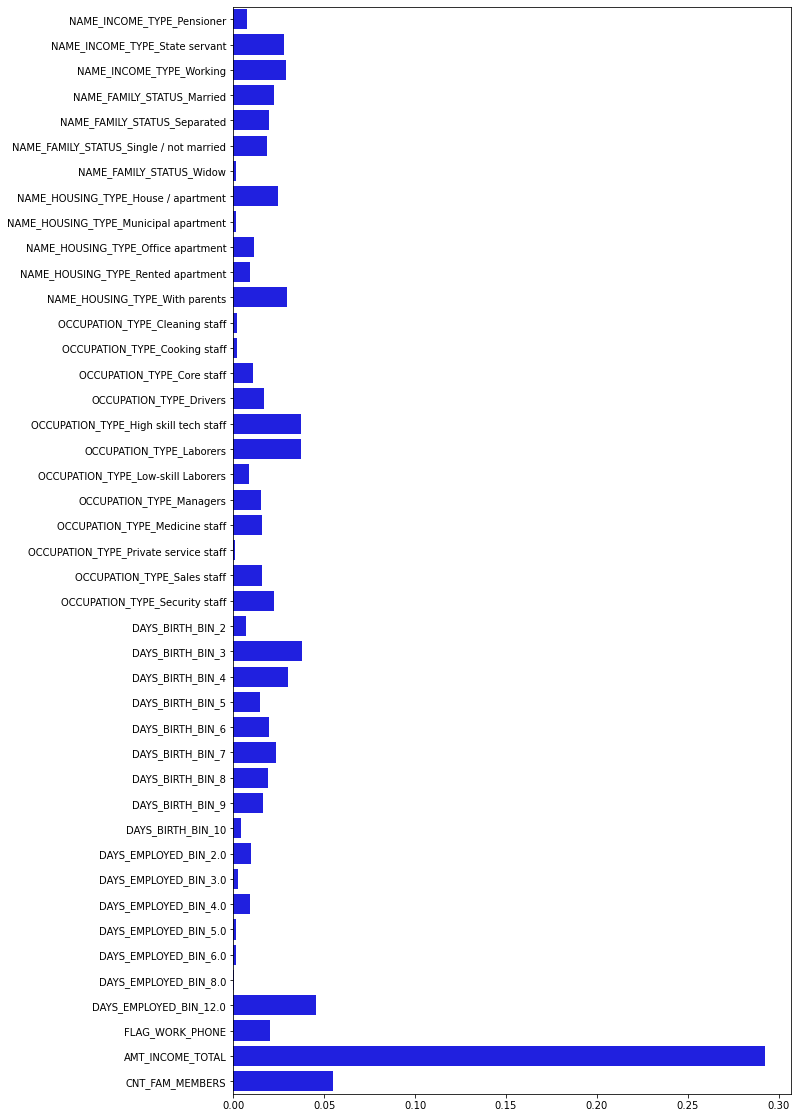

In [87]:
# Cheking the importance of the features used in the model
ax, fig = plt.subplots(figsize = (10, 20))
sns.barplot(y = model_ds.feature_names_in_, x = model_ds.feature_importances_, orient = 'h', color = 'blue')

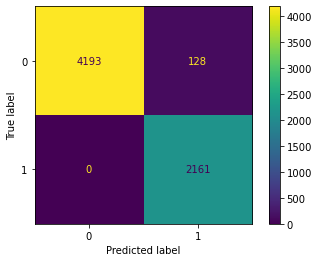

In [88]:
# Checking confusion matrix from the result on test data set
confusion_mtrx = confusion_matrix(y_test, model_ds.predict(x_test), labels = model_ds.classes_)
cfm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mtrx, display_labels = model_ds.classes_)
cfm_display.plot()

In [89]:
# Important classification model metrics
print(classification_report(y_test, model_ds.predict(x_test), labels = model_ds.classes_))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4321
           1       0.94      1.00      0.97      2161

    accuracy                           0.98      6482
   macro avg       0.97      0.99      0.98      6482
weighted avg       0.98      0.98      0.98      6482



# Conclusion

We have successfully created a model which can classify defaulters from non-defaulters with a good accuracy. In this process we have oversampled minor class which is default class. We have to adjust the probability of default for that reason. This is another exercise which will be taken up after this stage.